# Notebook 05 — Model Evaluation & Robustness

This notebook is the **storytelling and analysis** layer for the project.

It:

1. **Reloads the trained baseline model** and reproduces the original test
   split from Notebook 04.
2. **Evaluates** the model (ROC AUC, PR AUC, accuracy, precision, recall).
3. Computes and prints **confusion counts** (TP, FP, TN, FN).
4. Plots **ROC** and **Precision–Recall** curves using `evaluation.py`.
5. Performs a simple **robustness check**:
   - main labels (`stress_labels.csv`, q = 0.95),
   - robustness labels (`stress_labels_q90.csv`, q = 0.90),
   - combined labels (`stress_labels_combined.csv`).
   For each set of labels we rebuild the dataset, retrain the same model
   and compare metrics in a small table.

In [2]:
#!/usr/bin/env python3
# Notebook 05 — Model Evaluation & Robustness

import os
import sys
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# Make project root the working directory
# ----------------------------------------------------------
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
os.chdir(PROJECT_ROOT)

# Add src/ to PYTHONPATH so "import bank_stress" works
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Running from:", Path.cwd())
print("SRC_DIR:", SRC_DIR)

Running from: /files/bank_stress_detection_project_datascience_class
SRC_DIR: /files/bank_stress_detection_project_datascience_class/src


In [3]:
from bank_stress.models import (
    DatasetPaths,
    train_baseline_logit,
    evaluate_model,
)

from bank_stress.evaluation import (
    rebuild_dataset_and_split,
    load_trained_model,
    evaluate_existing_model,
    compute_confusion_counts,
    plot_roc_and_pr_curves,
)

# ----------------------------------------------------------
# Define directories and file paths
# ----------------------------------------------------------
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
FIGURES_DIR = RESULTS_DIR / "figures"
MODEL_DIR = RESULTS_DIR / "models"
METRICS_DIR = RESULTS_DIR / "metrics"

# Ensure folders exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# Input CSV paths
STRESS_INDEX_PATH = PROCESSED_DIR / "stress_index.csv"
LABELS_MAIN_PATH = PROCESSED_DIR / "stress_labels.csv"
LABELS_Q90_PATH = PROCESSED_DIR / "stress_labels_q90.csv"
LABELS_COMBINED_PATH = PROCESSED_DIR / "stress_labels_combined.csv"

# Trained model path
MODEL_PATH = MODEL_DIR / "baseline_logit.joblib"

# Required files
for path in [
    STRESS_INDEX_PATH,
    LABELS_MAIN_PATH,
    MODEL_PATH,
]:
    if not path.exists():
        raise FileNotFoundError(f"Required file missing: {path}")

print("Stress index CSV: ", STRESS_INDEX_PATH)
print("Main labels CSV:", LABELS_MAIN_PATH)
print("Model path:      ", MODEL_PATH)

# Evaluation settings
LAGS = 5
SPLIT_DATE = "2018-01-01"

Stress index CSV:  /files/bank_stress_detection_project_datascience_class/data/processed/stress_index.csv
Main labels CSV: /files/bank_stress_detection_project_datascience_class/data/processed/stress_labels.csv
Model path:       /files/bank_stress_detection_project_datascience_class/results/models/baseline_logit.joblib


In [4]:
# Rebuild dataset and split using the MAIN labels
paths_main = DatasetPaths(
    stress_index_path=STRESS_INDEX_PATH,
    labels_path=LABELS_MAIN_PATH,
)

x_train, x_test, y_train, y_test = rebuild_dataset_and_split(
    paths=paths_main,
    lags=LAGS,
    split_date=SPLIT_DATE,
)

print("\n=== Rebuilt dataset (main labels) ===")
print("Train shape:", x_train.shape)
print("Test shape: ", x_test.shape)
print("Train stress share:", float(y_train.mean().round(4)))
print("Test stress share: ", float(y_test.mean().round(4)))
print("Train period:", x_train.index.min(), "→", x_train.index.max())
print("Test period: ", x_test.index.min(), "→", x_test.index.max())

# Load previously trained baseline model (Notebook 04)
baseline_model = load_trained_model(MODEL_PATH)
print("\nLoaded model:")
print(baseline_model)


=== Rebuilt dataset (main labels) ===
Train shape: (1688, 8)
Test shape:  (661, 8)
Train stress share: 0.0634
Test stress share:  0.0166
Train period: 2000-01-12 05:00:00 → 2017-12-29 05:00:00
Test period:  2018-01-02 05:00:00 → 2025-11-21 05:00:00

Loaded model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('logit',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=0))])



=== Test set metrics ===
     roc_auc: 1.000
avg_precision: 1.000
    accuracy: 0.986
 precision_1: 0.550
    recall_1: 1.000

=== Classification report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       650
           1       0.55      1.00      0.71        11

    accuracy                           0.99       661
   macro avg       0.78      0.99      0.85       661
weighted avg       0.99      0.99      0.99       661


=== Main-spec metrics (q = 0.95) ===
     roc_auc: 1.000
avg_precision: 1.000
    accuracy: 0.986
 precision_1: 0.550
    recall_1: 1.000

=== Confusion counts (rows=true, cols=pred) ===
[[641   9]
 [  0  11]]
TN=641, FP=9, FN=0, TP=11


/opt/conda/lib/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


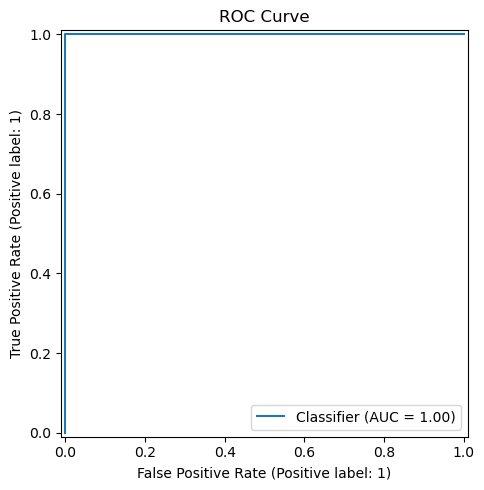

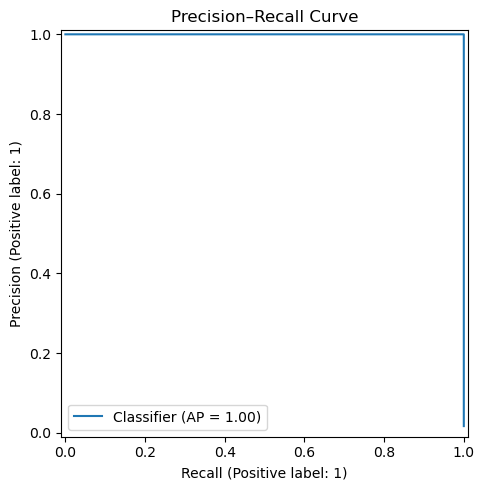


Saved ROC curve to: /files/bank_stress_detection_project_datascience_class/results/figures/baseline_logit_main_roc_curve.png
Saved PR curve to:  /files/bank_stress_detection_project_datascience_class/results/figures/baseline_logit_main_pr_curve.png


In [5]:
# Evaluate existing model on the rebuilt test set
metrics_main, prob_pos_main = evaluate_existing_model(
    model=baseline_model,
    features_test=x_test,
    labels_test=y_test,
)

print("\n=== Main-spec metrics (q = 0.95) ===")
for name, value in metrics_main.items():
    print(f"{name:>12}: {value:.3f}")

# Confusion counts
y_pred_main = pd.Series(
    baseline_model.predict(x_test),
    index=y_test.index,
    name="y_pred",
)
conf_counts_main = compute_confusion_counts(y_true=y_test, y_pred=y_pred_main)

# ROC + PR curves (saved to results/figures/)
if prob_pos_main is not None:
    roc_path, pr_path = plot_roc_and_pr_curves(
        y_test=y_test,
        prob_pos=prob_pos_main,
        output_dir=FIGURES_DIR,
        prefix="baseline_logit_main",
        show_plots=True,
    )
    print("\nSaved ROC curve to:", roc_path)
    print("Saved PR curve to: ", pr_path)
else:
    print("Could not compute probability scores — skipping ROC/PR plots.")

## Robustness: Different Label Constructions

Here we compare model performance under different label definitions:

- **Main**: q = 0.95 (`stress_labels.csv`)
- **Robustness**: q = 0.90 (`stress_labels_q90.csv`)
- **Combined**: threshold + crisis overrides (`stress_labels_combined.csv`)

For each label file we:

1. Rebuild the dataset (same stress index, different labels).
2. Apply the same time-based train/test split.
3. Retrain the baseline logistic regression.
4. Evaluate metrics on the corresponding test set.

In [6]:
specs = [
    ("q=0.95 (main)", LABELS_MAIN_PATH),
    ("q=0.90 (robustness)", LABELS_Q90_PATH),
    ("combined labels", LABELS_COMBINED_PATH),
]

robustness_rows = []

for spec_name, labels_path in specs:
    if not labels_path.exists():
        print(f"Skipping {spec_name}, file not found: {labels_path}")
        continue

    print(f"\n=== Evaluating spec: {spec_name} ===")
    paths_spec = DatasetPaths(
        stress_index_path=STRESS_INDEX_PATH,
        labels_path=labels_path,
    )

    # Rebuild features/labels and split
    x_train_spec, x_test_spec, y_train_spec, y_test_spec = (
        rebuild_dataset_and_split(
            paths=paths_spec,
            lags=LAGS,
            split_date=SPLIT_DATE,
        )
    )

    # Retrain the same baseline model structure on this label definition
    model_spec = train_baseline_logit(
        features_train=x_train_spec,
        labels_train=y_train_spec,
        c_param=1.0,
        solver="lbfgs",
        random_state=0,
    )

    # Evaluate
    metrics_spec = evaluate_model(
        model=model_spec,
        features_test=x_test_spec,
        labels_test=y_test_spec,
    )

    robustness_rows.append(
        {
            "spec": spec_name,
            "roc_auc": metrics_spec["roc_auc"],
            "avg_precision": metrics_spec["avg_precision"],
            "recall_1": metrics_spec["recall_1"],
        }
    )

robustness_df = pd.DataFrame(robustness_rows)
display(robustness_df)

# Save robustness table
robustness_path = METRICS_DIR / "robustness_metrics.csv"
robustness_df.to_csv(robustness_path, index=False)
print("\nSaved robustness metrics to:", robustness_path)


=== Evaluating spec: q=0.95 (main) ===

=== Test set metrics ===
     roc_auc: 1.000
avg_precision: 1.000
    accuracy: 0.986
 precision_1: 0.550
    recall_1: 1.000

=== Classification report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       650
           1       0.55      1.00      0.71        11

    accuracy                           0.99       661
   macro avg       0.78      0.99      0.85       661
weighted avg       0.99      0.99      0.99       661


=== Evaluating spec: q=0.90 (robustness) ===

=== Test set metrics ===
     roc_auc: 0.999
avg_precision: 0.995
    accuracy: 0.986
 precision_1: 0.875
    recall_1: 0.961

=== Classification report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       610
           1       0.88      0.96      0.92        51

    accuracy                           0.99       661
   macro avg       0.94      0.97      0.95       661

,spec,roc_auc,avg_precision,recall_1
0,q=0.95 (main),1.000000,1.000000,1.000000
1,q=0.90 (robustness),0.999486,0.994637,0.960784
2,combined labels,0.640623,0.412470,0.600000



Saved robustness metrics to: /files/bank_stress_detection_project_datascience_class/results/metrics/robustness_metrics.csv


### Conclusion

In this notebook I evaluated the baseline logistic-regression model on the
market-based stress index and compared several labeling schemes. Using my main
specification (q = 0.95 threshold labels), the model achieves very strong
discrimination between calm and stress days: ROC–AUC and average precision are
both essentially 1, recall for stress days is 1, and precision is around 0.55.
This pattern is consistent with a highly imbalanced setting, where the model
correctly flags nearly all rare stress episodes at the cost of some false
alarms. When I lower the threshold to q = 0.90, more days are labeled as
“stress” and the classification task becomes harder: ROC–AUC remains high but
accuracy and recall deteriorate, showing that the model is mainly tuned to
capture the most extreme tail events. Finally, when I use combined labels that
mix threshold and event-window information, performance drops markedly, which
suggests that these labels are only partially explained by the market-based
features. Overall, the results indicate that a simple logistic model on the
constructed stress index is very effective at identifying extreme stress, while
being less reliable for moderate or event-driven episodes. These findings will
be useful when interpreting the stress predictions in the main analysis.